In [ ]:
!pip install yfinance
!pip install stock-pandas

from sklearn.preprocessing import MinMaxScaler
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import yfinance as yf
import pandas as pd
import stock_pandas as spd
import matplotlib.pyplot as plt

import datetime
import requests
import json

     |████████████████████████████████| 5.5MB 17.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=b0f5e370023397a440f648e39e2e258d673bc004a616d3ed3f4e0cc5dc1d8b65
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 143kB 17.7MB/s 
  Created wheel for stock-pandas: filename=stock_pandas-0.29.3-cp37-cp37m-linux_x86_64.whl size=279614 sha256=21e354a504a66aaa48e9aa23473a40af17267988fd5a8a4e403d5f0268301b05
  Stored in directory: /root/.cache/pip/wheels/0c/5c/9d/ed62405c29e1832cb29a9ef54a74b81d672b22b8c8e9bd3c22
Successfully built stock-pandas


In [ ]:
startDate,startYear = '1993-01-29',1993
endDate,endYear = '2021-03-19',2021

SPY = spd.StockDataFrame(yf.download('SPY',start=startDate,end=endDate))
SPY.drop(columns='Adj Close',inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
def getUSstat(startYear,endYear):
  headers = {'Content-type': 'application/json'}
  allSeries = pd.DataFrame(columns=['CUUR0000SA0','LAURD910000000000003','LAURD920000000000003','LAURD930000000000003','LAURD940000000000003'])
  for start in range(startYear,endYear,10):
    end = endYear if start+9 > endYear else start+9
    print(start,end)
    data = json.dumps({"seriesid": ['CUUR0000SA0','LAURD910000000000003','LAURD920000000000003','LAURD930000000000003','LAURD940000000000003'],"startyear":start, "endyear":end})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)
    print(json_data)
    if json_data['status'] == 'REQUEST_SUCCEEDED':
      tS = pd.DataFrame()
      for series in json_data['Results']['series']:
        df = pd.DataFrame(columns=['date','periodName','value','footnotes'])
        seriesId = series['seriesID']
        for item in series['data']:
          item['date'] = datetime.datetime.strptime(item['year'] + '-' + item['period'][1:3], '%Y-%m')
          df = df.append(pd.DataFrame(item))
        df = df.set_index('date')
        df = df.drop(columns=['footnotes','periodName','period','year'])
        df = df.rename(columns = {'value':seriesId})
        tS[seriesId] = pd.to_numeric(df[seriesId], errors='coerce')
      allSeries = allSeries.add(tS, fill_value=0)
  return allSeries

# if USstat.empty:
USstat = getUSstat(startYear,endYear) 
USstat = USstat.astype(float)
USstat['unemployment_rate'] = (USstat['LAURD910000000000003'] + USstat['LAURD920000000000003'] + USstat['LAURD930000000000003'] + USstat['LAURD940000000000003']) / 4
USstat = USstat.rename(columns = {'CUUR0000SA0': 'consumer_price_index'})

USstat = USstat.resample('D').interpolate()
USstat = USstat.resample('B').interpolate()
USstat.dropna(inplace=True)
USstat

1993 2002
{'status': 'REQUEST_SUCCEEDED', 'responseTime': 530, 'message': [], 'Results': {'series': [{'seriesID': 'CUUR0000SA0', 'data': [{'year': '2002', 'period': 'M12', 'periodName': 'December', 'value': '180.9', 'footnotes': [{}]}, {'year': '2002', 'period': 'M11', 'periodName': 'November', 'value': '181.3', 'footnotes': [{}]}, {'year': '2002', 'period': 'M10', 'periodName': 'October', 'value': '181.3', 'footnotes': [{}]}, {'year': '2002', 'period': 'M09', 'periodName': 'September', 'value': '181.0', 'footnotes': [{}]}, {'year': '2002', 'period': 'M08', 'periodName': 'August', 'value': '180.7', 'footnotes': [{}]}, {'year': '2002', 'period': 'M07', 'periodName': 'July', 'value': '180.1', 'footnotes': [{}]}, {'year': '2002', 'period': 'M06', 'periodName': 'June', 'value': '179.9', 'footnotes': [{}]}, {'year': '2002', 'period': 'M05', 'periodName': 'May', 'value': '179.8', 'footnotes': [{}]}, {'year': '2002', 'period': 'M04', 'periodName': 'April', 'value': '179.8', 'footnotes': [{}]}

,consumer_price_index,LAURD910000000000003,LAURD920000000000003,LAURD930000000000003,LAURD940000000000003,unemployment_rate
date,,,,,,
1993-01-01,142.600000,8.700000,7.1,7.500000,9.100000,8.100000
1993-01-04,142.648387,8.690323,7.1,7.470968,9.090323,8.087903
1993-01-05,142.664516,8.687097,7.1,7.461290,9.087097,8.083871
1993-01-06,142.680645,8.683871,7.1,7.451613,9.083871,8.079839
1993-01-07,142.696774,8.680645,7.1,7.441935,9.080645,8.075806
...,...,...,...,...,...,...
2021-01-26,262.736839,8.300000,5.8,6.000000,8.000000,7.025000
2021-01-27,262.783032,8.300000,5.8,6.000000,8.000000,7.025000
2021-01-28,262.829226,8.300000,5.8,6.000000,8.000000,7.025000


In [ ]:
network_input = SPY.join(USstat[['consumer_price_index','unemployment_rate']])
network_input.fillna(method='ffill',inplace=True)

In [ ]:
network_input[['Close','Open','High','Low']] = network_input[['Close','Open','High','Low']].div(network_input['unemployment_rate'].values,axis=0)
network_input

,Open,High,Low,Close,Volume,consumer_price_index,unemployment_rate
Date,,,,,,,
1993-01-29,5.504973,5.504973,5.477585,5.501060,1003200,143.051613,7.987097
1993-02-01,5.513323,5.548589,5.513323,5.548589,480500,143.100000,7.975000
1993-02-02,5.555867,5.575499,5.544088,5.571573,201300,143.117857,7.958929
1993-02-03,5.590715,5.645796,5.586781,5.641862,529400,143.135714,7.942857
1993-02-04,5.673012,5.688781,5.609935,5.676954,531500,143.153571,7.926786
...,...,...,...,...,...,...,...
2021-03-12,55.810677,56.115301,55.686834,56.093950,64608100,263.014000,7.025000
2021-03-15,56.132382,56.468328,55.804982,56.428470,73427200,263.014000,7.025000
2021-03-16,56.522421,56.630603,56.239144,56.357296,72958000,263.014000,7.025000


,Open,High,Low,Close,Volume,consumer_price_index,unemployment_rate
Date,,,,,,,
1993-01-29,5.504973,5.504973,5.477585,5.501060,1003200,143.051613,7.987097
1993-02-01,5.513323,5.548589,5.513323,5.548589,480500,143.100000,7.975000
1993-02-02,5.555867,5.575499,5.544088,5.571573,201300,143.117857,7.958929
1993-02-03,5.590715,5.645796,5.586781,5.641862,529400,143.135714,7.942857
1993-02-04,5.673012,5.688781,5.609935,5.676954,531500,143.153571,7.926786
...,...,...,...,...,...,...,...
2021-03-12,55.810677,56.115301,55.686834,56.093950,64608100,263.014000,7.025000
2021-03-15,56.132382,56.468328,55.804982,56.428470,73427200,263.014000,7.025000
2021-03-16,56.522421,56.630603,56.239144,56.357296,72958000,263.014000,7.025000


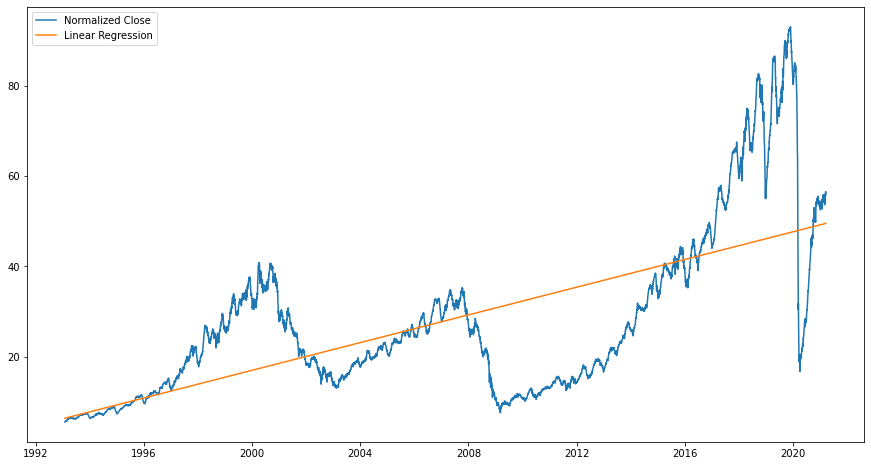

In [ ]:
from sklearn.linear_model import LinearRegression

dates_to_array = lambda df: (df.index - df.index.min())/np.timedelta64(1, 'D')

network_input_date = dates_to_array(network_input)

sp500_linear_training_data = network_input['Close']
sp500_linear_training_dates = dates_to_array(sp500_linear_training_data)
linear_X = np.array(sp500_linear_training_dates).reshape(-1, 1)
linear_y = np.array(sp500_linear_training_data).reshape(-1, 1)
linear_reg = LinearRegression()
linear_reg = linear_reg.fit(linear_X, linear_y)
linear_preds = linear_reg.predict(np.array(dates_to_array(network_input)).reshape(-1, 1))[:,0]

plt.figure(figsize=(15, 8))
plt.plot(network_input.index, network_input['Close'], label='Normalized Close')
plt.plot(network_input.index, linear_preds, label='Linear Regression')
plt.legend()

network_input

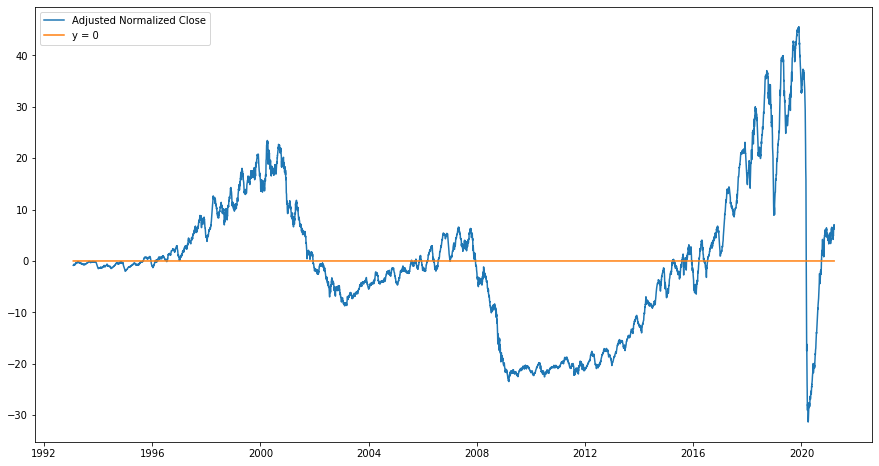

In [ ]:
network_input[['Close','Open','High','Low']] = network_input[['Close','Open','High','Low']].subtract(linear_preds,axis=0)

plt.figure(figsize=(15, 8))
plt.plot(network_input.index, network_input['Close'], label='Adjusted Normalized Close')
plt.plot(network_input.index, [0 for i in range(0, len(network_input))], label='y = 0')
plt.legend()

In [ ]:
network_input['Shift'] = network_input['Close'].shift(-1)
network_input

,Open,High,Low,Close,Volume,consumer_price_index,unemployment_rate,Shift
Date,,,,,,,,
1993-01-29,-0.839767,-0.839767,-0.867155,-0.843679,1003200,143.051613,7.987097,-0.808748
1993-02-01,-0.844014,-0.808748,-0.844014,-0.808748,480500,143.100000,7.975000,-0.789964
1993-02-02,-0.805669,-0.786037,-0.817449,-0.789964,201300,143.117857,7.958929,-0.723874
1993-02-03,-0.775021,-0.719940,-0.778955,-0.723874,529400,143.135714,7.942857,-0.692981
1993-02-04,-0.696923,-0.681154,-0.760001,-0.692981,531500,143.153571,7.926786,-0.689597
...,...,...,...,...,...,...,...,...
2021-03-12,6.343276,6.647900,6.219433,6.626548,64608100,263.014000,7.025000,6.948471
2021-03-15,6.652383,6.988328,6.324982,6.948471,73427200,263.014000,7.025000,6.873097
2021-03-16,7.038222,7.146404,6.754945,6.873097,72958000,263.014000,7.025000,7.061069


In [ ]:
split_percent = 0.8
split = int(len(network_input) * split_percent)

out_scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = MinMaxScaler(feature_range=(-1, 1))
out_scaler.fit_transform(network_input[network_input.columns[:-1]])
network_input = pd.DataFrame(scaler.fit_transform(network_input))

print(network_input)
lookback = 365
forcasting = network_input[network_input.columns[:-1]][-lookback:].values
fc_g = network_input[network_input.columns[-1]][-lookback:].values


network_input.dropna(inplace=True)
trainX,trainY = network_input[network_input.columns[:-1]].values[:split],network_input[network_input.columns[-1]].values[:split]
testX,testY = network_input[network_input.columns[:-1]].values[split:],network_input[network_input.columns[-1]].values[split:]


G_lookback = 30
G_batch_size = 1

from keras.preprocessing.sequence import TimeseriesGenerator
trainG,testG = TimeseriesGenerator(trainX, trainY, length=G_lookback, batch_size=G_batch_size,sampling_rate=1),TimeseriesGenerator(testX, testY, length=G_lookback, batch_size=G_batch_size ,sampling_rate=1)
fG = TimeseriesGenerator(forcasting, fc_g, length=G_lookback, batch_size=G_batch_size)


forcasting = forcasting.reshape((forcasting.shape[0], 1, forcasting.shape[1]))
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))

print(np.isnan(trainX).any(),
np.isnan(trainY).any(),
np.isnan(testX).any(),
np.isnan(testY).any())
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

             0         1         2  ...         5         6         7
0    -0.204254 -0.214835 -0.201963  ... -1.000000 -0.183878 -0.206226
1    -0.204365 -0.214023 -0.201360  ... -0.999193 -0.185996 -0.205738
2    -0.203365 -0.213428 -0.200668  ... -0.998896 -0.188809 -0.204019
3    -0.202565 -0.211698 -0.199664  ... -0.998598 -0.191622 -0.203216
4    -0.200528 -0.210683 -0.199170  ... -0.998300 -0.194436 -0.203128
...        ...       ...       ...  ...       ...       ...       ...
7080 -0.016887 -0.018846 -0.017244  ...  1.000000 -0.352298 -0.004486
7081 -0.008824 -0.009935 -0.014492  ...  1.000000 -0.352298 -0.006446
7082  0.001240 -0.005797 -0.003285  ...  1.000000 -0.352298 -0.001557
7083 -0.008301 -0.004827 -0.009999  ...  1.000000 -0.352298 -0.023064
7084 -0.008596 -0.010153 -0.019570  ...  1.000000 -0.352298       NaN

[7085 rows x 8 columns]
False False False False
(5668, 1, 7) (5668,) (1416, 1, 7) (1416,)


In [ ]:
# design network
from keras.layers import LSTM, Dense, Dropout
model = keras.Sequential()
model.add(LSTM(825,input_shape=(G_lookback, trainX.shape[2])))
model.add(Dense(1))
opt = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='mae', optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 825)               2748900   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 826       
Total params: 2,749,726
Trainable params: 2,749,726
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
5638/5638 - 40s - loss: 0.0172 - val_loss: 0.3514
Epoch 2/100
5638/5638 - 38s - loss: 0.0162 - val_loss: 0.2837
Epoch 3/100
5638/5638 - 38s - loss: 0.0141 - val_loss: 0.2401
Epoch 4/100
5638/5638 - 38s - loss: 0.0122 - val_loss: 0.2243
Epoch 5/100
5638/5638 - 38s - loss: 0.0111 - val_loss: 0.2346
Epoch 6/100
5638/5638 - 38s - loss: 0.0102 - val_loss: 0.2509
Epoch 7/100
5638/5638 - 38s - loss: 0.0098 - val_loss: 0.2536
Epoch 8/100
5638/5638 - 38s - loss: 0.0093 - val_loss: 0.2728
Epoch 9/100
5638/5638 - 38s - loss: 0.0093 - val_loss: 0.2564
Epoch 10/100
5638/5638 - 38s - loss: 0.0090 - val_loss: 0.2486
Epoch 11/100
5638/5638 - 38s - loss: 0.0088 - val_loss: 0.2386
Epoch 12/100
5638/5638 - 38s - loss: 0.0086 - val_loss: 0.2317
Epoch 13/100
5638/5638 - 38s - loss: 0.0085 - val_loss: 0.2402
Epoch 14/100
5638/5638 - 38s - loss: 0.0083 - val_loss: 0.2589
Epoch 15/100
5638/5638 - 38s - loss: 0.0082 - val_loss: 0.2440
Epoch 16/100
5638/5638 - 38s - loss: 0.0081 - val_loss: 0.2304
E

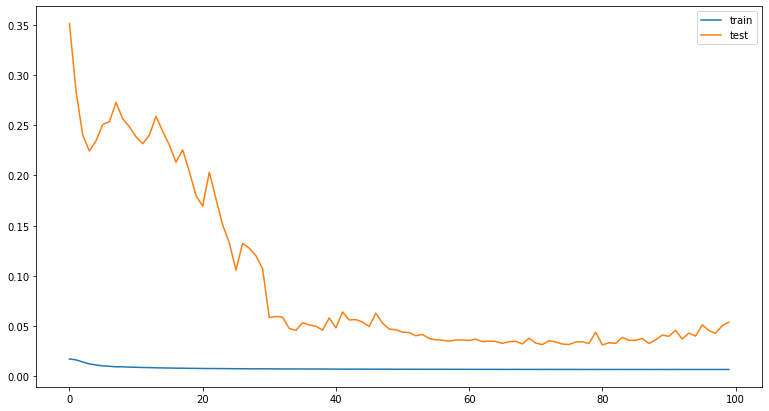

In [ ]:
# fit network
history = model.fit(trainG,epochs=100, validation_data=(testG), verbose=2, shuffle=False)
# plot history
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend()

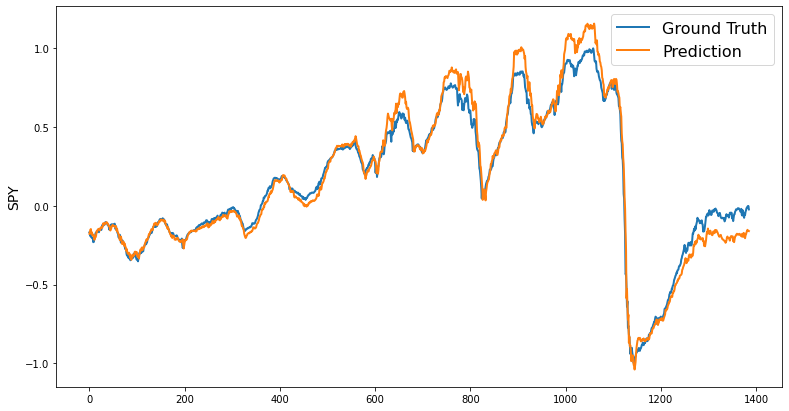

In [ ]:
prediction = model.predict(testG)

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(testY[G_lookback:], label='Ground Truth', linewidth=2)
ax.plot(prediction, label='Prediction', linewidth=2)
ax.set_ylabel('SPY', fontsize=14)
ax.legend(loc='best', fontsize=16)

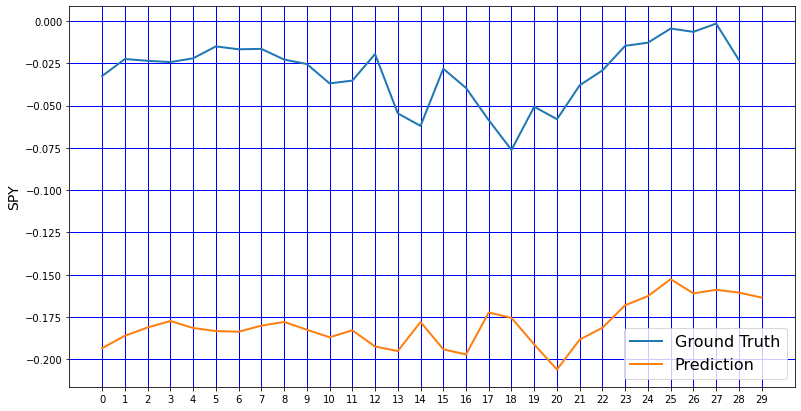

In [ ]:
fy = model.predict(fG)
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(testY[-29:], label='Ground Truth', linewidth=2)
ax.plot(fy[-30:], label='Prediction', linewidth=2)
ax.set_xticks(list(range(30)))
ax.grid(color='b', linestyle='-', linewidth=1)
ax.set_ylabel('SPY', fontsize=14)
ax.legend(loc='best', fontsize=16)